# Baseline model
As mentioned in our project proposal, our baseline model will be a random forest classifier trained with scikit-learn.

In [1]:
# package imports
import numpy as np
import matplotlib.pyplot as plt
import joblib

# need pip install sklearn
try: # x86-64 specific sklearn acceleration, assume intelex=2023.3, sklearn=1.4
    from sklearnex import patch_sklearn
    patch_sklearn(global_patch=True)
except (AttributeError, ModuleNotFoundError) as e:
    print('x86 patch error, defaulting to regular sklearn')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from skimage.feature import hog

try: # CUDA-specific install if running on Colab
    %load_ext cudf.pandas
except ModuleNotFoundError:
    print('CuDF not installed, defaulting to regular pandas')
import pandas as pd

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CuDF not installed, defaulting to regular pandas


## Data loading and preparation

In [2]:
# load Pickle object and get a sense of what we're working with
images = joblib.load('../data/set.pkl')
labels = np.unique(images['Genus'])
print('keys:', images.keys())
print('labels:', labels)
print('image sizes:', images['Image'][0].shape)

keys: Index(['Path', 'Genus', 'Image'], dtype='object')
labels: ['Auricularia' 'Cookeina' 'Entoloma' 'Fomitiporia' 'Geastrum' 'Hygrocybe'
 'Hymenochaete' 'Marasmius' 'Ophiocordyceps' 'Oudemansiella' 'Phallus'
 'Pluteus' 'Schizophyllum' 'Trametes' 'Xylaria']
image sizes: (15,)


Note that these images are in grayscale, to facilitate HOG feature extraction. Our main model uses all colour channels.

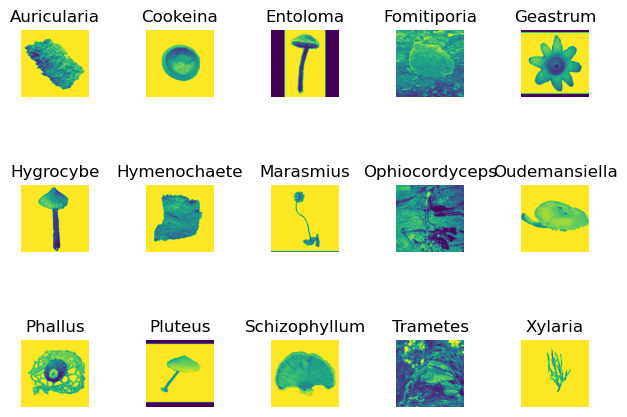

In [3]:
# display first instance of each class
def plot_classes() -> None:
    fig, axes = plt.subplots(nrows=3, ncols=5) # define plot shape
    fig.tight_layout()
    
    for axis, label in zip(axes.flat, labels):
        first_ind = images[images['Genus'] == label]
        axis.imshow(first_ind.loc[0, 'Image'])
        axis.axis('off')
        axis.title.set_text(label)

plot_classes()

One notable deviation from the project proposal is the use of histogram of oriented gradients (HOG). Because deep convolutional networks do feature detection automatically and random forest doesn't, our interest in using HOG is primarily to do feature extraction before training.

In [4]:
def hog_features(image):
    """
    Extracts features from an image by using histogram of oriented gradients (HOG).
    This boosts performance for traditional non-CNN statistical learning techniques.
    :param image: that we apply HOG onto
    :return: extracted features
    """
    features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

def extract_features(data) -> list:
    """
    Wrapper for HOG feature extraction function.
    :param data: array of data
    :return: array of HOG-generated features
    """
    x_features = []
    for ind, img in enumerate(data):
        x_features.append(hog_features(img))
    return x_features

In [5]:
# splitting dataset into training/testing
test_size = 0.2 # change if needed

x = np.array(images['Image']) # x: data
y = np.array(images['Genus']) # y: label
x_train_pre, x_test_pre, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True, stratify=y) # use default random state
x_train = extract_features(x_train_pre) # extract features from training set
x_test = extract_features(x_test_pre) # extract from testing set

print('Training set size:', len(x_train_pre))
print('Test set size:', len(x_test))

Training set size: 5513
Test set size: 1379


## Training

In [6]:
def train(features_x, labels_y, classifier: str = 'RandomForestClassifier'):
    """
    :param features_x: 2D array of features/data points
    :param labels_y: 1D array of target values/labels to be predicted
    :param classifier: string name for the classifier. accepts 'RandomForestClassifier', 'SVC'
    :return: The classifier itself
    """
    if classifier == 'RandomForestClassifier':
        rf = RandomForestClassifier(n_estimators=750)
        rf.fit(features_x, labels_y)
        return rf
    elif classifier == 'SVC': # this will probably overload your memory with the x86 patch
        svc = SVC(C=5, probability=True)
        svc.fit(features_x, labels_y)
        return svc
    else:
        raise ValueError("Invalid model type passed for training")

In [7]:
# train the model
classifier = train(x_train, y_train, classifier='RandomForestClassifier')

## Performance assessments

In [8]:
# make predictions and assess model
x_pred = classifier.predict(x_test)
report = classification_report(y_test, x_pred, output_dict=True)
print(classification_report(y_test, x_pred))

                precision    recall  f1-score   support

   Auricularia       0.29      0.27      0.28        78
      Cookeina       0.64      0.76      0.70       144
      Entoloma       0.79      0.28      0.41        97
   Fomitiporia       0.46      0.54      0.50        48
      Geastrum       0.93      0.41      0.57        69
     Hygrocybe       0.36      0.77      0.49       196
  Hymenochaete       0.78      0.15      0.25        48
     Marasmius       0.55      0.83      0.66       225
Ophiocordyceps       0.80      0.59      0.68        97
 Oudemansiella       0.96      0.27      0.42        93
       Phallus       0.50      0.46      0.48        69
       Pluteus       1.00      0.43      0.60        49
 Schizophyllum       0.83      0.10      0.18        50
      Trametes       0.56      0.44      0.49        64
       Xylaria       1.00      0.08      0.14        52

      accuracy                           0.53      1379
     macro avg       0.70      0.42      0.46 

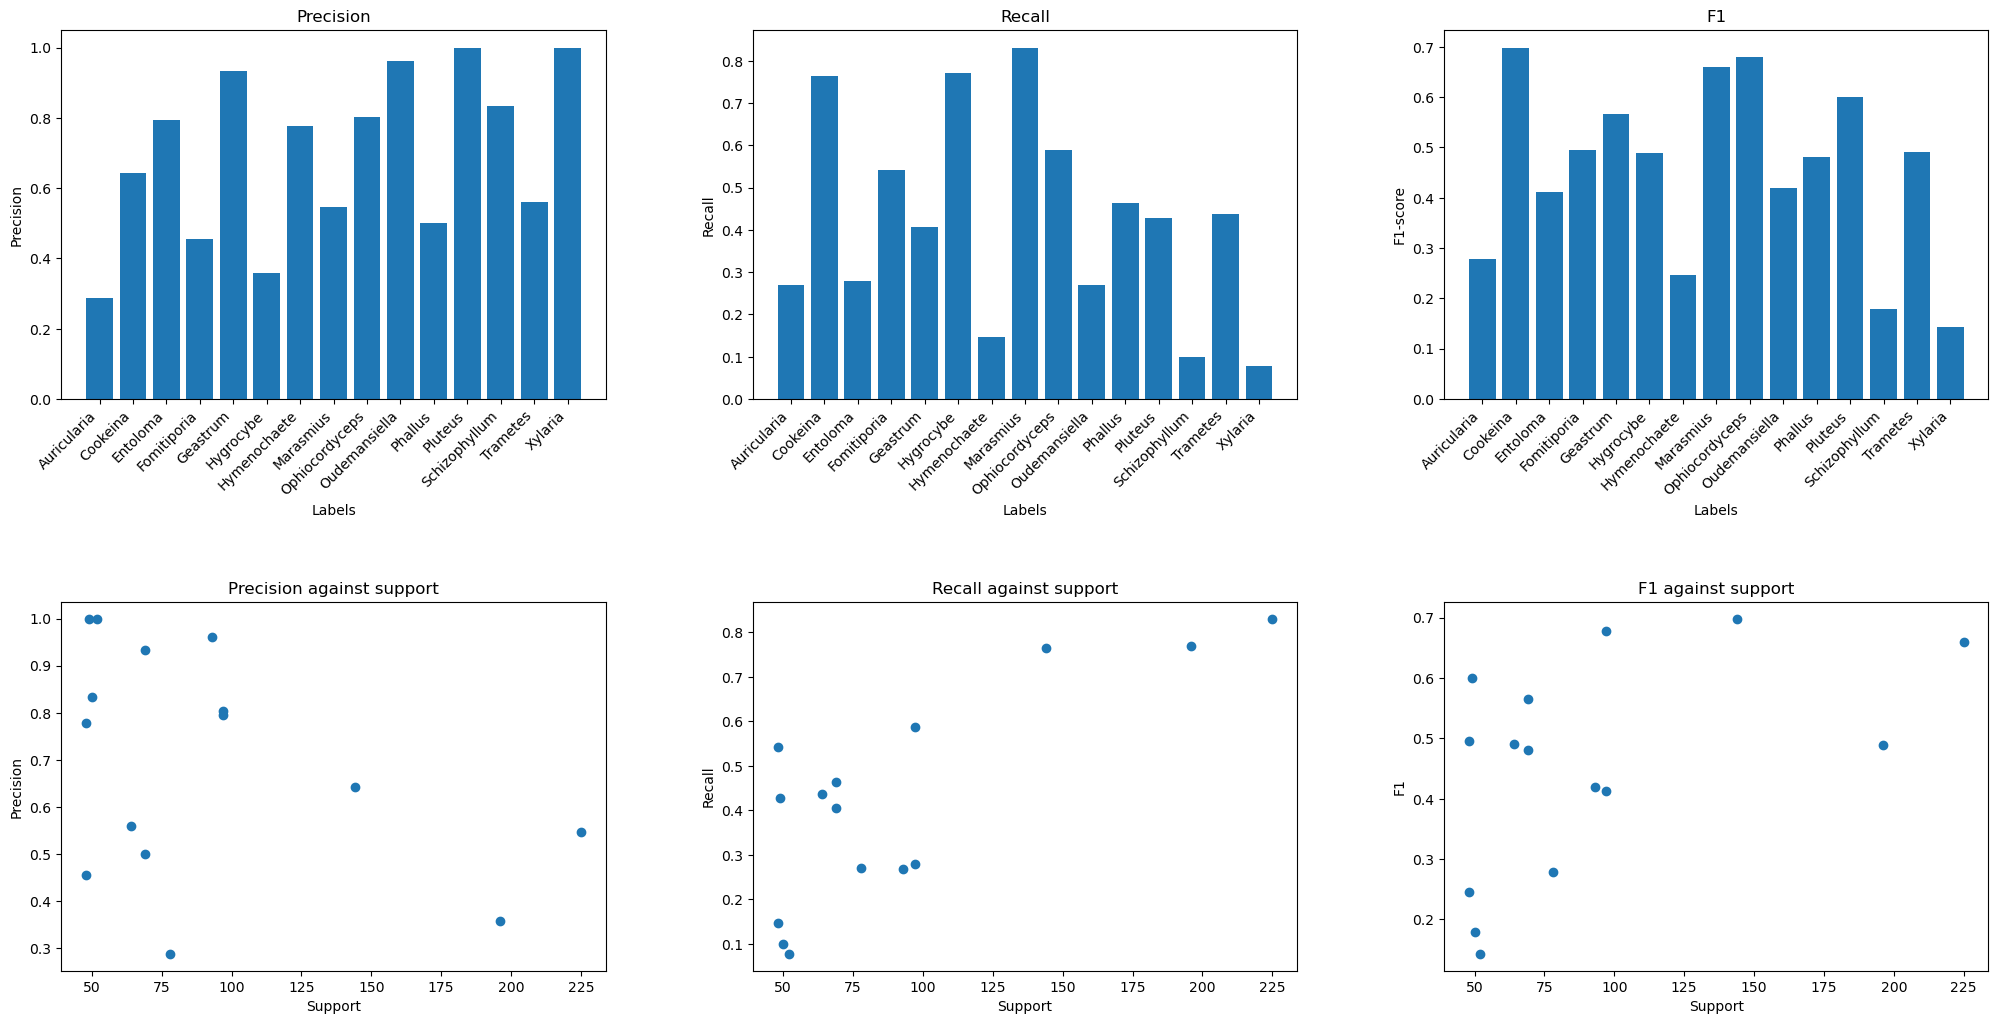

In [9]:
# plot classification report
def get_metric_arrays(cl_report: dict):
    """
    Converts a scikit-learn classification report output into four NumPy arrays in class order
    :param cl_report: dictionary output of classification_report()
    :return: precision, recall, f1, support arrays
    """
    num_classes = len(cl_report) - 3 # accounts for accuracy and averages
    precision = np.empty(num_classes) # initialise empty arrays to encode values
    recall = np.empty(num_classes)
    f1 = np.empty(num_classes)
    support = np.empty(num_classes)
    
    for index, subdict in enumerate(cl_report.values()): # convert dict values to np array
        if index == 15: break
        precision[index] = subdict['precision']
        recall[index] = subdict['recall']
        f1[index] = subdict['f1-score']
        support[index] = subdict['support']
    return precision, recall, f1, support
    
def plot_classification_report(cl_report: dict, rotation: int=45) -> None:
    """
    Plots scikit-learn's classification report.
    :param cl_report: the report output of classification_report(), as a dict
    :param rotation: optional parameter for rotation of x_labels
    """
    precision, recall, f1, support = get_metric_arrays(cl_report) # get arrays for each metric
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10)) # define plot shape
    fig.tight_layout(h_pad=12.5, w_pad=7.5)

    # precision
    axes[0][0].bar(labels, precision)
    axes[0][0].set_xlabel('Labels')
    axes[0][0].set_ylabel('Precision')
    axes[0][0].set_title('Precision')
    plt.setp(axes[0][0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    axes[1][0].scatter(support, precision)
    axes[1][0].set_xlabel('Support')
    axes[1][0].set_ylabel('Precision')
    axes[1][0].set_title('Precision against support')
    
    # recall
    axes[0][1].bar(labels, recall)
    axes[0][1].set_xlabel('Labels')
    axes[0][1].set_ylabel('Recall')
    axes[0][1].set_title('Recall')
    plt.setp(axes[0][1].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    axes[1][1].scatter(support, recall)
    axes[1][1].set_xlabel('Support')
    axes[1][1].set_ylabel('Recall')
    axes[1][1].set_title('Recall against support')
    
    # f1
    axes[0][2].bar(labels, f1)
    axes[0][2].set_xlabel('Labels')
    axes[0][2].set_ylabel('F1-score')
    axes[0][2].set_title('F1')
    plt.setp(axes[0][2].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    axes[1][2].scatter(support, f1)
    axes[1][2].set_xlabel('Support')
    axes[1][2].set_ylabel('F1')
    axes[1][2].set_title('F1 against support')
    
plot_classification_report(report)

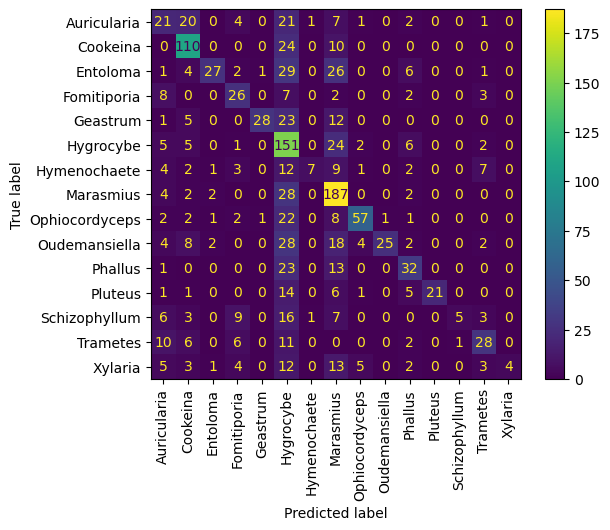

In [10]:
cm = confusion_matrix(y_test, x_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(xticks_rotation='vertical')